In [1]:
import pandas as pd
import json

class InitialSetup:
    def __init__(self, csv_file_path, json_file_path):   
        """
        Initializes the InitialSetup with paths to site and source data files.
        
        Parameters:
        -----------
        csv_file_path : str
            The file path to the CSV file containing site data.
        json_file_path : str
            The file path to the JSON file containing source data.
        
        Attributes:
        -----------
        site_data : pandas.DataFrame
            A dataframe containing the processed site data.
        num_sites : int
            The number of site locations.
        source_data : dict
            A dictionary containing the processed source data.
        num_sources : int
            The number of earthquake sources.
        """
        self.site_data, self.num_sites = self.read_site_data(csv_file_path)
        self.source_data, self.num_sources = self.read_source_data(json_file_path)
        self.extract_source_data()
        self.extract_site_data()

    def read_site_data(self, file_path):
        """
        Reads a CSV file and processes it to ensure it has the required columns.
        Also calculates the number of sites (rows) in the data.

        Parameters:
        -----------
        file_path (str): 
            Path to the CSV file.

        Returns:
        -----------
        site_data (pandas dataframe): 
            A data frame with the processed data.
        num_sites (int): 
            Number of sites (rows) in the DataFrame.
        """
        # Read the CSV file
        try:
            site_data = pd.read_csv(file_path)
        except Exception as e:
            raise IOError(f"Error reading the file: {e}")

        # Validate the columns
        required_columns = ['id', 'latitude', 'longitude', 'depth', 'vs30', 'condition']
        if not all(column in site_data.columns for column in required_columns):
            raise ValueError(f"The CSV file must contain the following columns: {required_columns}")

        # Calculate the number of sites
        num_sites = site_data.shape[0]

        return site_data, num_sites

    def read_source_data(self, file_path):
        """
        Reads earthquake source characteristics from a JSON file.
    
        Parameters:
        -----------
        file_path (str): 
            Path to the JSON file.
    
        Returns:
        -----------
        source_data (dict): 
            Dictionary containing earthquake source data.
        num_sources (int):
            Number of earthquake sources in the data.
        """
        try:
            with open(file_path, 'r') as file:
                source_data = json.load(file)
            
            num_sources = len(source_data)
            return source_data, num_sources
    
        except Exception as e:
            raise IOError(f"Error reading the file: {e}")

    def extract_source_data(self):
        """Extracts parameters from each source in source_data."""
        self.source_m_min = {name: data["M_min"] for name, data in self.source_data.items()}
        self.source_m_max = {name: data["M_max"] for name, data in self.source_data.items()}
        self.source_nu = {name: data["nu"] for name, data in self.source_data.items()}
        self.source_lat = {name: data["lat"] for name, data in self.source_data.items()}
        self.source_lon = {name: data["lon"] for name, data in self.source_data.items()}
        self.source_depth = {name: data["depth"] for name, data in self.source_data.items()}
        self.source_strike = {name: data["strike"] for name, data in self.source_data.items()}
        self.source_dip = {name: data["dip"] for name, data in self.source_data.items()}
        self.source_mechanism = {name: data["mechanism"] for name, data in self.source_data.items()}
        self.source_event_type = {name: data["event_type"] for name, data in self.source_data.items()}
    
        # Determining the overall min and max magnitudes
        self.m_min_min = max(self.source_m_min.values())
        self.m_max_max = min(self.source_m_max.values())

    def extract_site_data(self):
        """Extracts parameters from each site in site_data"""
        self.site_id  = self.site_data['id']
        self.site_lat = self.site_data['latitude']
        self.site_lon = self.site_data['longitude']
        self.site_depth = self.site_data['depth']
        self.site_vs30 = self.site_data['vs30']
        self.site_condition = self.site_data['condition']

In [2]:
import numpy as np

class SeismicDistanceCalculator:
    
    @staticmethod
    def calculate_rupture_distance(site_loc, source_loc, strike, dip):
        """
        Calculates the shortest distance from a site location to a rupture plane (Rrup).
        
        Parameters:
        -----------
        site_loc : tuple of float
            Coordinates of site location (latitude, longitude, depth) in decimal degrees and km.
        source_loc : tuple of float
            Coordinates of the top edge of the rupture plane (latitude, longitude, depth) in decimal degrees and km.
        strike : float
            Strike angle of the rupture plane in degrees.
        dip : float
            Dip angle of the rupture plane in degrees.
            
        Returns:
        --------
        float: Shortest distance from the site location to the rupture plane in km (Rrup).
        """
        x1, y1, z1 = site_loc
        x2, y2, z2 = source_loc
    
        strike_radians = np.radians(strike)
        dip_radians    = np.radians(dip)
        
        # Calculate normal vector to rupture plane
        nx = np.sin(dip_radians) * np.sin(strike_radians)
        ny = -np.sin(dip_radians) * np.cos(strike_radians)
        nz = np.cos(dip_radians)
        
        # Calculate distance from site location to rupture plane
        Rrup = abs(nx * (x1 - x2) + ny * (y1 - y2) + nz * (z1 - z2)) / np.sqrt(nx ** 2 + ny ** 2 + nz ** 2)
    
        return Rrup
    
    @staticmethod
    def calculate_joyner_boore_distance(site_loc, source_loc):
        """
        Calculates the Joyner-Boore distance (Rjb) between two points based on their longitude and latitude.
    
        Parameters:
        -----------
        site_loc : tuple of float
            Coordinates of site location (latitude, longitude) in decimal degrees.
        source_loc : tuple of float
            Coordinates of the top edge of the rupture plane (latitude, longitude) in decimal degrees.
    
        Returns:
        --------
        float: Joyner-Boore distance between the site and source in km (Rjb).
        """
         # Extract latitude and longitude from the input tuples
        site_lat, site_lon, depth = site_loc
        source_lat, source_lon, depth = source_loc
    
        # Radius of the Earth in kilometers
        R = 6371
    
        # Convert latitude and longitude from degrees to radians
        site_lat, site_lon, source_lat, source_lon = map(np.radians, [site_lat, site_lon, source_lat, source_lon])
    
        # Haversine formula
        dlon = source_lon - site_lon
        dlat = source_lat - site_lat
        a = np.sin(dlat / 2)**2 + np.cos(site_lat) * np.cos(source_lat) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
        # Distance in kilometers
        Rjb = R * c
    
        return Rjb

    @staticmethod
    def calculate_horizontal_distance(site_loc, source_loc, strike):
        """
        Calculates the horizontal distance (Rx) from the top edge of the rupture to a site location,
        measured perpendicular to the fault strike.
    
        Parameters:
        -----------
        site_loc : tuple of float
            Coordinates of site location (latitude, longitude, depth) in decimal degrees and km.
        source_loc : tuple of float
            Coordinates of the top edge of the rupture plane (latitude, longitude, depth) in decimal degrees and km.
        strike : float
            Fault strike angle in degrees.
    
        Returns:
        --------
        float: Horizontal distance from the top edge of the rupture to the site location, measured perpendicular
               to the fault strike in km (Rx).
        """
        # Convert strike to radians
        strike_rad = np.radians(strike)
        
        # Calculate unit vector along strike direction
        strike_vector = np.array([-np.sin(strike_rad), np.cos(strike_rad), 0])
        
        # Calculate vector from top edge of rupture plane to site
        top_edge_to_site = np.array(site_loc) - np.array(source_loc)
        
        # Calculate distance from site to closest point on rupture trace
        dist_to_rupture_trace = np.dot(top_edge_to_site, strike_vector)
        Rx = abs(dist_to_rupture_trace)
        
        return Rx

    @staticmethod
    def calculate_haversine_distance(lat1, lon1, lat2, lon2):
        """
        Calculates the Haversine distance between two points based on their latitude and longitude coordinates.
        
        Parameters:
        -----------
        lat1, lon1 : float
            Latitude and longitude of the first point in degrees.
        lat2, lon2 : float
            Latitude and longitude of the second point in degrees.
        
        Returns:
        --------
        float: The Haversine distance between the two points in km (Rh).
        """
        R = 6371  # Earth radius in kilometers
        
        dLat = np.radians(lat2 - lat1)
        dLon = np.radians(lon2 - lon1)
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)

        a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        Rh = R*c
        
        return Rh

In [3]:
import numpy as np

class MagnitudeFrequencyDistribution:
    
    @staticmethod
    def gr_recurrence_law(Magnitudes, m_min, m_max):
        """
        Computes the probability of earthquakes in a particular region using the Gutenberg-Richter recurrence law
    
        Parameters:
        -----------
        Magnitudes : float
            An array of magnitude values.   
        m_min : float
            The minimum magnitude of earthquakes considered in the analysis.
        m_max : float
            The maximum magnitude of earthquakes considered in the analysis.          
    
        Returns:
        --------
        probability : numpy.ndarray
            An array of corresponding probability for each magnitude value in Magnitudes.
        pdf : numpy.ndarray
            An array of corresponding pdf for each magnitude value in Magnitudes.
        """
        b_value     = 1  # The b-value of the Gutenberg-Richter recurrence law describes the relationship between the magnitude and frequency of earthquakes.
        probability = 10 ** (-b_value * (Magnitudes - m_min))
        pdf         = (b_value*np.log(10)*10**(-b_value*(Magnitudes-m_min)))/(1-10**(-b_value*(m_max-m_min)))

        return probability , pdf

In [4]:

from modules.seismic_distance_calculator import SeismicDistanceCalculator
from modules.magnitude_frequency_distribution import MagnitudeFrequencyDistribution
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import pygmm

class EarthquakeGenerator:
    def __init__(self, setup, magnitude_frequency_distribution, ground_motion_equation_model, ground_motion_type, num_scenarios, period=None):
        """
        Initializes the EarthquakeGenerator with necessary parameters for seismic hazard analysis.

        Parameters:
        -----------
        setup : object
            An instance of setup class containing site and source data.
        magnitude_frequency_distribution : str
            Name of the magnitude frequency distribution function to use.
        ground_motion_equation_model : str
            Name of the ground motion equation model to use.
        ground_motion_type : str
            Type of ground motion to analyze ('PGA', 'PGV', or 'SA').
        num_scenarios : int
            Number of earthquake scenarios to generate.
        period : float, optional
            The period of interest in seconds for spectral acceleration (SA).
        """
        self.setup = setup
        self.num_scenarios = num_scenarios
        self.magnitude_frequency_distribution = getattr(MagnitudeFrequencyDistribution, magnitude_frequency_distribution)
        self.ground_motion_type = ground_motion_type
        self.period = period
        self.ground_motion_equation_model = ground_motion_equation_model

    def generate_scenarios(self):
        """
        Generates earthquake scenarios with associated magnitudes and sources.

        Returns:
        --------
        tuple: A tuple containing arrays of magnitudes and corresponding source names.
        """
        # Generate linearly spaced magnitudes within the specified range.
        Magnitudes = np.linspace(self.setup.m_min_min, self.setup.m_max_max, self.num_scenarios)

        # Calculate the probability of each magnitude for each source.
        probabilities = {
            source_name: self.magnitude_frequency_distribution(Magnitudes, self.setup.source_m_min[source_name], self.setup.source_m_max[source_name])[0]
            for source_name in self.setup.source_data
        }

        # Sum the probabilities across all sources, weighted by the annual rate of exceedance.
        prob_of_magnitudes = np.sum([self.setup.source_nu[source_name] * probabilities[source_name] for source_name in self.setup.source_data], axis=0)
        # Normalize the probabilities to sum to 1.
        prob_of_magnitudes /= np.sum(prob_of_magnitudes)

        # Select magnitudes based on the calculated probabilities.
        magnitudes = np.random.choice(Magnitudes, size=self.num_scenarios, p=prob_of_magnitudes)

        # Calculate the probability of each source given the selected magnitudes.
        prob_of_magnitudes_given_source = {
            source_name: self.magnitude_frequency_distribution(magnitudes, self.setup.source_m_min[source_name], self.setup.source_m_max[source_name])[0]
            for source_name in self.setup.source_data
        }

        # Normalize the probabilities of sources given the magnitude.
        prob_of_sources_given_magnitude = np.transpose([
            self.setup.source_nu[source_name] * prob_of_magnitudes_given_source[source_name] /
            sum(self.setup.source_nu[source_name] * prob_of_magnitudes_given_source[source_name] for source_name in self.setup.source_data)
            for source_name in self.setup.source_data
        ])

        # Select sources for each scenario based on the calculated probabilities.
        sources = [list(self.setup.source_data.keys())[np.random.choice(range(self.setup.num_sources), p=prob)]
                 for prob in prob_of_sources_given_magnitude]

        return magnitudes, sources

    def calculate_ground_motion_parameters(self, magnitudes, sources):
        """
        Calculates the median ground motion parameters and the associated standard deviations.

        Returns:
        --------
        tuple: A tuple containing dictionaries for median ground motion, intra-event std, and inter-event std.
        """
        def _get_gm_indices(model_class, ground_motion_type):
            if ground_motion_type == 'PGA':
                return model_class.INDEX_PGA
            elif ground_motion_type == 'PGV':
                return model_class.INDEX_PGV
            elif ground_motion_type == 'SA':
                return model_class.INDICES_PSA
            else:
                raise ValueError("Invalid ground motion type. Choose 'PGA', 'PGV', or 'SA'.")

        median_ground_motion, intra_event_std, inter_event_std = {}, {}, {}

        for i, magnitude in enumerate(magnitudes):
          source_info = self.setup.source_data[sources[i]]
          source_loc = (source_info['lat'], source_info['lon'], source_info['depth'])

          for j, site_id in enumerate(self.setup.site_id):
            site_loc   = (self.setup.site_lat[j], self.setup.site_lon[j], self.setup.site_depth[j])

            rupture_distance      = SeismicDistanceCalculator.calculate_rupture_distance(site_loc, source_loc, source_info['strike'], source_info['dip'])
            joyner_boore_distance = SeismicDistanceCalculator.calculate_joyner_boore_distance(site_loc, source_loc)
            horizontal_distance   = SeismicDistanceCalculator.calculate_horizontal_distance(site_loc, source_loc, source_info['strike'])

            model_class = getattr(pygmm, self.ground_motion_equation_model)
            gm_index    = _get_gm_indices(model_class, self.ground_motion_type)

            scenario = pygmm.Scenario(mag=magnitude, dist_rup=rupture_distance, dist_jb=joyner_boore_distance, dist_x=horizontal_distance, site_cond=self.setup.site_condition[j], v_s30=self.setup.site_vs30[j] , dip=source_info['dip'], mechanism=source_info['mechanism'], event_type=source_info['event_type'])
            model    = model_class(scenario)

            if self.ground_motion_type == 'PGA':
                median_ground_motion[site_id, i] = model.pga
            elif self.ground_motion_type == 'PGV':
                median_ground_motion[site_id, i] = model.pgv
            elif self.ground_motion_type == 'SA':
                median_ground_motion[site_id, i] = model.spec_accels
            else:
                raise ValueError("Invalid ground motion type. Choose 'PGA', 'PGV', or 'SA'.")

            intra_event_std[site_id, i] = model._calc_ln_std()[2][gm_index]
            inter_event_std[site_id, i] = model._calc_ln_std()[1][gm_index]

            # v_ref     = 1180 # Consider refernce velocity as 1180 m/s
            # resp_ref  = np.exp(model._calc_ln_resp(v_ref, np.nan))

            # intra_event_std[site_id, i] = model._calc_ln_std(resp_ref)[2][gm_index]
            # inter_event_std[site_id, i] = model._calc_ln_std(resp_ref)[1][gm_index]

        return median_ground_motion, intra_event_std, inter_event_std

    def generate_norm_inter_event_residuals(self, inter_event_std):
        """
        Generates a set of normalized inter-event residuals for each scenario.

        Parameters:
        -----------
        inter_event_std : dict
            A dictionary with (site_id, scenario_index) as keys and standard deviation of inter-event residuals as values.

        Returns:
        --------
        dict: A dictionary with (site_id, scenario_index) as keys and normalized inter-event residuals as values.
        """

        norm_inter_event_residuals = {}
        # Generate normalized inter-event residuals for each scenario.
        for i in range(self.num_scenarios):
            Eta = np.random.normal(0, 1)
            # Base standard deviation for normalization
            base_inter_event_std = inter_event_std[self.setup.site_id[0], i]  
            for j, site_id in enumerate(self.setup.site_id):
                norm_inter_event_residuals[site_id, i] = (base_inter_event_std/inter_event_std[site_id, i]) * Eta

        return norm_inter_event_residuals

    def generate_norm_intra_event_residuals(self):
        """
        Generates a set of intra-event residuals using a spatial correlation model.

        Returns:
        --------
        dict: A dictionary with (site_id, scenario_index) as keys and intra-event residuals as values.
        """
        def determine_range_parameter_by_ground_motion_type(vs30, ground_motion_type, period):
            """
            Determine the range parameter (b) for the correlation model given Vs30 values,
            the ground motion type (PGA, PGV, or SA), and period if applicable.

            Parameters:
            vs30 (pd.Series): A Pandas series containing Vs30 values at different locations.
            ground_motion_type (str): Type of ground motion ('PGA', 'PGV', or 'SA').
            period (float, optional): The period of interest in seconds for 'SA'.

            Returns:
            float: The range parameter b for the correlation model.
            """
            std_vs30 = vs30.std()
            clustering_threshold = 50

            if ground_motion_type == 'PGA' or ground_motion_type == 'SA':
                if period is None and ground_motion_type == 'SA':
                    raise ValueError("Period must be provided for Spectral Acceleration (SA).")
                period = 0 if ground_motion_type == 'PGA' else period

                case = 1 if std_vs30 > clustering_threshold else 2

                if period < 1:
                    if case == 1:
                        b = 8.5 + 17.2 * period
                    else:
                        b = 40.7 - 15.0 * period
                else:
                    b = 22.0 + 3.7 * period

            elif ground_motion_type == 'PGV':
                b = 83.4

            else:
                raise ValueError("Invalid ground motion type. Choose 'PGA', 'PGV', or 'SA'.")

            return b

        # Range parameter b based on ground motion type.
        b = determine_range_parameter_by_ground_motion_type(self.setup.site_vs30, self.ground_motion_type, self.period)

        # Coordinate matrix for sites.
        coords = np.column_stack((self.setup.site_lat, self.setup.site_lon))

        norm_intra_event_residuals = {}
        # Generate residuals for each scenario.
        for i in range(self.num_scenarios):
            # Calculate the pairwise Haversine distance matrix for the current scenario's source location.
            distances = pdist(coords, lambda u, v: SeismicDistanceCalculator.calculate_haversine_distance(u[0], u[1], v[0], v[1]))

            # Convert distance matrix to a square-form and calculate the correlation matrix.
            corr_matrix = np.exp(-3 * squareform(distances) / b)

            # Set the diagonal to 1 to ensure positive definiteness.
            np.fill_diagonal(corr_matrix, 1)

            # Generate the intra-event residuals for this scenario using the correlation matrix.
            epsilon = np.random.multivariate_normal(np.zeros(self.setup.num_sites), corr_matrix)

            # Assign residuals to each site for the current scenario.
            for j, site_id in enumerate(self.setup.site_id):
                norm_intra_event_residuals[site_id, i] = epsilon[j]

        return norm_intra_event_residuals

    def generate_earthquake_objects(self):
        """
        Generates a dictionary of earthquake objects with calculated intensity measures.

        Returns:
        --------
        dict: A dictionary with tuples of (site_id, scenario_index) as keys and intensity measure values as values.
        """
        magnitudes, sources  = self.generate_scenarios()
        median_ground_motion, intra_event_std, inter_event_std = self.calculate_ground_motion_parameters(magnitudes, sources)
        norm_inter_event_residual = self.generate_norm_inter_event_residuals(inter_event_std)
        norm_intra_event_residual = self.generate_norm_intra_event_residuals()

        intensity_measure_dict = {}
        intensity_measure_data = []
        for i, magnitude in enumerate(magnitudes):
            source_info = self.setup.source_data[sources[i]]
            for j, site_id in enumerate(self.setup.site_id):
                im_value = np.exp(np.log(median_ground_motion[site_id, i]) +
                                  intra_event_std[site_id, i] * norm_intra_event_residual[site_id, i] +
                                  inter_event_std[site_id, i] * norm_inter_event_residual[site_id, i])

                distance = SeismicDistanceCalculator.calculate_haversine_distance(self.setup.site_lat[j], self.setup.site_lon[j],  source_info['lat'], source_info['lon'])

                intensity_measure_dict[(site_id, i, magnitude, distance)] = im_value
                intensity_measure_data.append([site_id, i, magnitude, distance, im_value])

        # Create a DataFrame from the intensity measures
        intensity_measure_df = pd.DataFrame(intensity_measure_data, columns=['site_id', 'scenarion_index', 'magnitude', 'distance', 'intensity_measure'])

        return intensity_measure_dict, intensity_measure_df

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap
from scipy.interpolate import griddata
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

class SeismicHazardVisualization:
    def __init__(self, setup, intensity_measures, return_period):
        """
        Initializes the SeismicHazardVisualization with necessary parameters for visualization.

        Parameters:
        -----------
        setup : object
            An instance of setup class containing site and source data.
        intensity_measures : dict
            A dictionary of intensity measures for each site and scenario.
        return_period : int
            The return period for seismic hazard analysis in years.
        """
        self.setup = setup
        self.intensity_measures = intensity_measures
        self.return_period = return_period

    def prepare_data(self, exceedance_probability):
        """
        Prepare the data for plotting based on the specified exceedance probability.

        Parameters:
        -----------
        exceedance_probability : float
            The exceedance probability for which to prepare the data.

        Returns:
        --------
        list
            A list of tuples containing latitude, longitude, and exceedance value for each site.
        """

        annual_exceedance_probability = 1 - (1 - exceedance_probability)**(1/self.return_period)

        processed_data = []
        for site_id in self.setup.site_data['id']:
            site_im_values = [im for (id, *rest), im in self.intensity_measures.items() if id == site_id]
            exceedance_value = np.percentile(site_im_values, 100 * (1 - annual_exceedance_probability))
            try:
                row = self.setup.site_data[self.setup.site_data['id'] == site_id].iloc[0]
                lat, lon = row['latitude'], row['longitude']
            except IndexError:
                print(f"Site ID {site_id} not found in site_data")

            processed_data.append((lat, lon, exceedance_value))
        return processed_data

    def generate_earthquake_geotiff(self, exceedance_probability, geotiff_file_path):
        """
        Prepares and returns geographic and exceedance data for sites above a specified probability threshold.
        Each site's data includes its latitude, longitude, and the exceedance value that meets or exceeds
        the given threshold, useful for spatial risk visualization.

        Parameters:
        -----------
        exceedance_probability : float
            The probability threshold for selecting sites, expressed as a decimal (e.g., 0.1 for 10% chance).

        Returns:
        --------
        list of tuples
            A list where each tuple contains latitude, longitude, and exceedance value for each selected site.
        """
        data = self.prepare_data(exceedance_probability)
        lats, lons, ims = zip(*data)

        west = min(lons)
        east = max(lons)
        north = max(lats)
        south = min(lats)

        # Define grid resolution
        pixel_width  = 0.01
        pixel_height = 0.01

        # Calculate grid dimensions
        width = int((east - west) / pixel_width)
        height = int((north - south) / pixel_height)

        # Create the transformation for the GeoTIFF
        transform = from_origin(west, north, pixel_width, -pixel_height)

        # Initialize the grid
        intensity_grid = np.full((height, width), np.nan, dtype='float32')

        # Populate the grid with intensity measures
        for lat, lon, im in zip(lats, lons, ims):
            # Calculate row and col indices
            lat_index  = int((north - lat) / pixel_height)
            lon_index  = int((lon - west) / pixel_width)

            # Ensure the indices do not exceed the grid dimensions
            row = max(0, min(lat_index, height - 1))
            col = max(0, min(lon_index, width - 1))

            # Assign the intensity measure to the correct grid cell
            intensity_grid[row, col] = im

        # Write the grid to a GeoTIFF file
        with rasterio.open(
            f'{geotiff_file_path}/intensity_measures.tif',
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=intensity_grid.dtype,
            crs='+proj=latlong',
            transform=transform,
        ) as dst:
            dst.write(intensity_grid, 1)

    def generate_continuous_earthquake_geotiff(self, exceedance_probability, grid_resolution, geotiff_file_path):
        """
        Generates a continuous raster GeoTIFF representing earthquake exceedance values over an area,
        based on interpolation of exceedance data at specific sites.

        Parameters:
        -----------
        exceedance_probability : float
            The probability threshold for selecting sites, expressed as a decimal (e.g., 0.1 for 10% chance).
        grid_resolution : float, optional
            The resolution of the grid in degrees, determining the spacing of points in the mesh.
            Default is 0.01 degrees.

        Returns:
        --------
        None
            Creates a GeoTIFF file named 'continuous_intensity_measures.tif' with the interpolated raster data.
        """

        data = self.prepare_data(exceedance_probability)
        lats, lons, ims = zip(*data)

        # Create a mesh grid covering the entire area of interest
        xi = np.arange(min(lons), max(lons), grid_resolution)
        yi = np.arange(min(lats), max(lats), grid_resolution)
        X, Y = np.meshgrid(xi, yi)

        # Interpolate intensity measures onto the mesh grid
        Z = griddata((lons, lats), ims, (X, Y), method='cubic')

        # Define the transformation for the GeoTIFF
        west, north = X.min(), Y.max()
        pixel_width, pixel_height = grid_resolution, grid_resolution
        transform = from_origin(west, north, pixel_width, -pixel_height)

        # Write the interpolated grid to a GeoTIFF file
        with rasterio.open(
            f'{geotiff_file_path}/continuous_intensity_measures.tif',
            'w',
            driver='GTiff',
            height=Z.shape[0],
            width=Z.shape[1],
            count=1,
            dtype=Z.dtype,
            crs='+proj=latlong',
            transform=transform,
        ) as dst:
            dst.write(Z, 1)

    def plot_hazard_map(self, exceedance_probability):
        """
        Plot the seismic hazard map with site locations and exceedance probability indicated.

        Parameters:
        -----------
        exceedance_probability : float
            The probability of exceedance to be visualized on the hazard map.
        """
        data = self.prepare_data(exceedance_probability)
        lats, lons, ims = zip(*data)

        plt.figure(figsize=(10, 8))
        plt.scatter(lons, lats, c=ims, cmap='Reds', marker='o', label='Site Locations')
        plt.colorbar(label='Intensity Measure at Exceedance Probability')

        # Plotting source locations
        source_lats, source_lons = zip(*[(source['lat'], source['lon']) for source in self.setup.source_data.values()])
        plt.scatter(source_lons, source_lats, c='yellow', marker='*', s=300, edgecolors='black', label='Source Locations')

        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Seismic Hazard Map - {self.return_period} years, {exceedance_probability*100}% Exceedance')
        plt.legend()
        plt.show()

    def plot_heatmap(self, exceedance_probability):
        """
        Plot a heatmap representing seismic hazard based on the exceedance probability.

        Parameters:
        -----------
        exceedance_probability : float
            The exceedance probability for which to generate the heatmap.
        """
        data = self.prepare_data(exceedance_probability)

        # Create a map centered around the mean latitude and longitude
        mean_lat = np.mean([lat for lat, _, _ in data])
        mean_lon = np.mean([lon for _, lon, _ in data])
        map_obj  = folium.Map(location=[mean_lat, mean_lon], zoom_start=5)

        # Add HeatMap layer
        heat_data = [[lat, lon, im] for lat, lon, im in data]
        HeatMap(heat_data).add_to(map_obj)

        return map_obj

    def plot_contour_map(self, exceedance_probability):
        """
        Plot a contour map representing seismic hazard based on the exceedance probability.

        Parameters:
        -----------
        exceedance_probability : float
            The exceedance probability for which to generate the contour map.
        """
        # Prepare the data
        data = self.prepare_data(exceedance_probability)
        lats, lons, ims = zip(*data)

        # Generate a grid to interpolate onto
        grid_lons, grid_lats = np.meshgrid(np.linspace(min(lons), max(lons), 100),
                                           np.linspace(min(lats), max(lats), 100))

        # Interpolate the data onto the grid
        grid_ims = griddata((lons, lats), ims, (grid_lons, grid_lats), method='cubic')

        # Create the contour plot
        plt.figure(figsize=(10, 6))
        contour = plt.contourf(grid_lons, grid_lats, grid_ims, levels=100, cmap='viridis')
        plt.colorbar(contour)

        for source_id, source_info in self.setup.source_data.items():
            plt.plot(source_info['lon'], source_info['lat'], '*', color='yellow', markersize=15, label='Source Locations')

        # Annotations and titles
        plt.title(f"Seismic Hazard Contour Map - {self.return_period} years, {exceedance_probability*100}% Exceedance")
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.show()

    def plot_tract_intensity_map(self, exceedance_probability, census_file_path):
        """
        Plot a map representing seismic hazard with intensity measure values averaged for each census tract.

        Parameters:
        -----------
        exceedance_probability : float
            The exceedance probability for which to generate the contour map.
        census_file_path : str
            The path to the shapefile for North America.
        """
        # Prepare the intensity measure data
        data = self.prepare_data(exceedance_probability)
        lats, lons, ims = zip(*data)

        # Create a GeoDataFrame from the intensity measure data
        points_df = pd.DataFrame({'intensity_measure': ims, 'geometry': [Point(lon, lat) for lon, lat in zip(lons, lats)]})
        points_gdf = gpd.GeoDataFrame(points_df, geometry='geometry')

        # Read the shapefile and ensure points_gdf has the same CRS as the shapefile data
        tracts_gdf = gpd.read_file(census_file_path)
        points_gdf.crs = tracts_gdf.crs

        # Perform a spatial join between the points and the tracts
        tracts_with_ims = gpd.sjoin(tracts_gdf, points_gdf, how="inner", predicate='contains')

        # Compute the mean intensity measure for each tract
        tract_intensity = tracts_with_ims.groupby('TRACTCE')['intensity_measure'].mean().reset_index()

        # Merge this back with the original tracts data
        tracts_gdf = tracts_gdf.merge(tract_intensity, on='TRACTCE', how='left')

        # Plot the tracts colored by the mean intensity measure
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        tracts_gdf.plot(column='intensity_measure', ax=ax, legend=True, cmap='viridis', missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values",
        })

        # Plot the seismic sources as yellow stars
        for source_info in self.setup.source_data.values():
            ax.plot(source_info['lon'], source_info['lat'], '*', color='yellow', markersize=15, label='Seismic Sources')

        # Annotations and titles
        plt.title(f"Seismic Hazard Map - {self.return_period} years, {exceedance_probability*100}% Exceedance Probability")
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.show()

In [4]:
import pandas as pd

csv_file_path   = 'input_files/site_data.csv'
df = pd.read_csv(csv_file_path)
df.head()

,id,latitude,longitude,depth,vs30,condition
0,47157021312,35.108533,-89.837289,0,250,soil'
1,47157021530,35.058529,-89.708563,0,250,soil'
2,47157021726,35.054941,-89.850607,0,250,soil'
3,47157022024,35.041668,-90.015503,0,250,soil'
4,47157000200,35.168239,-90.043007,0,250,soil'


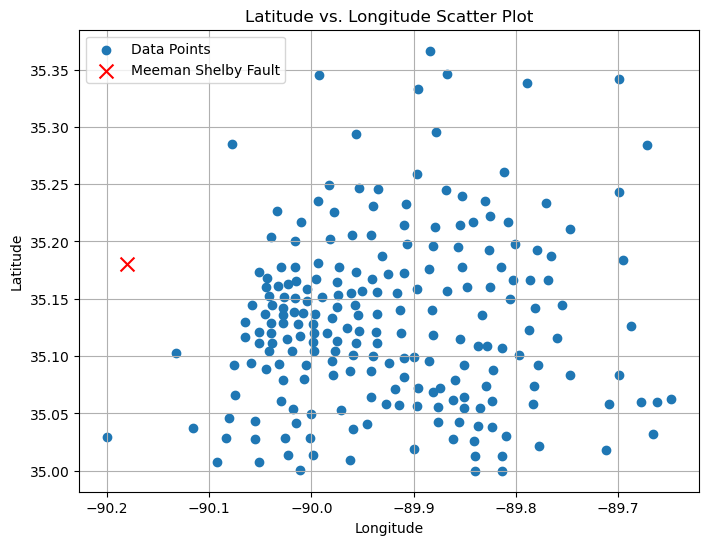

In [5]:
import matplotlib.pyplot as plt



# Sample data (replace this with your actual dataset)
data = df[['id', 'latitude', 'longitude']]

# Coordinates of the "Meeman Shelby Fault" (from the provided JSON)
fault_lat = 35.18
fault_lon = -90.18

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data["longitude"], data["latitude"], label="Data Points")
plt.scatter(fault_lon, fault_lat, color="red", label="Meeman Shelby Fault", marker="x", s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Latitude vs. Longitude Scatter Plot")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import folium

# Sample data (replace this with your actual dataset)
data = df[['id', 'latitude', 'longitude']]

# Coordinates of the "Meeman Shelby Fault" (from the provided JSON)
fault_lat = 35.18
fault_lon = -90.18

# Create map centered at mean latitude and longitude of data
mean_lat = sum(data["latitude"]) / len(data["latitude"])
mean_lon = sum(data["longitude"]) / len(data["longitude"])
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=10)

# Add markers for data points
for lat, lon, id in zip(data["latitude"], data["longitude"], data["id"]):
    folium.Marker([lat, lon], popup=f"ID: {id}").add_to(m)

# Add marker for the "Meeman Shelby Fault"
folium.Marker([fault_lat, fault_lon], popup="Meeman Shelby Fault", icon=folium.Icon(color='red')).add_to(m)

# Save the map to an HTML file
m.save('map.html')

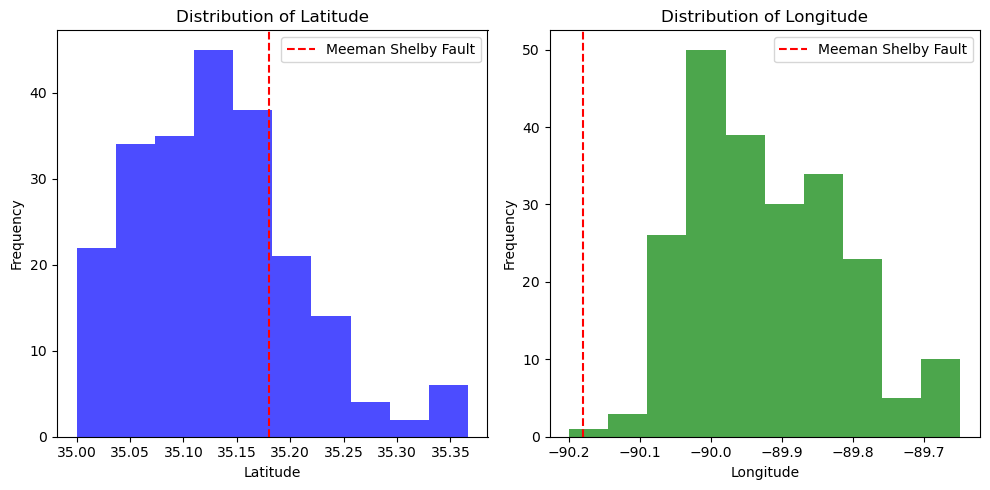

In [8]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual dataset)
data = df[['id', 'latitude', 'longitude']]

# Coordinates of the "Meeman Shelby Fault" (from the provided JSON)
fault_lat = 35.18
fault_lon = -90.18

# Create histograms for latitude and longitude
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(data["latitude"], bins=10, color='blue', alpha=0.7)
plt.axvline(x=fault_lat, color='red', linestyle='--', label="Meeman Shelby Fault")
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Distribution of Latitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(data["longitude"], bins=10, color='green', alpha=0.7)
plt.axvline(x=fault_lon, color='red', linestyle='--', label="Meeman Shelby Fault")
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Distribution of Longitude')
plt.legend()

plt.tight_layout()
plt.show()

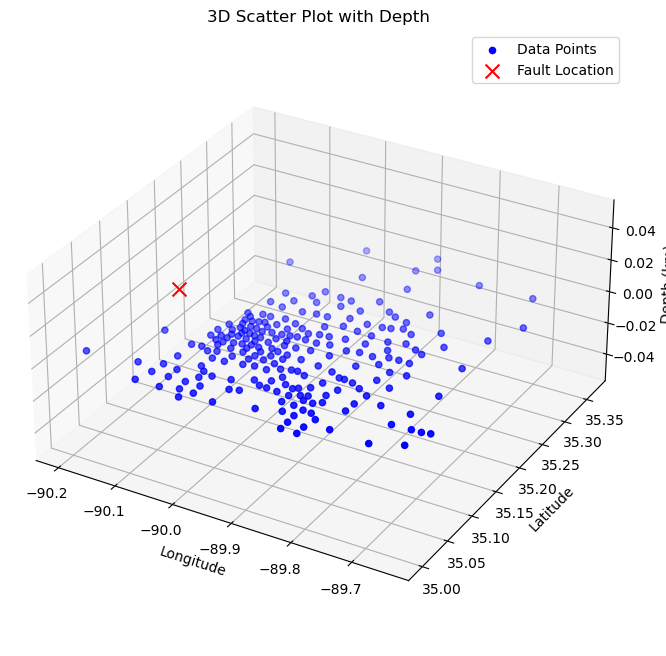

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data (replace this with your actual dataset)
data = df[['id', 'latitude', 'longitude', 'depth']]

# Coordinates of the "Meeman Shelby Fault" (from the provided JSON)
fault_lat = 35.18
fault_lon = -90.18

# Convert latitude, longitude, and depth to numpy arrays
latitude = np.array(data["latitude"])
longitude = np.array(data["longitude"])
depth = np.array(data["depth"])

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points
ax.scatter(longitude, latitude, depth, c='b', marker='o', label='Data Points')

# Plot the Meeman Shelby Fault location
ax.scatter(fault_lon, fault_lat, 0, c='r', marker='x', s=100, label='Fault Location')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
ax.set_title('3D Scatter Plot with Depth')

# Set aspect ratio
ax.set_box_aspect([1,1,0.5])  # Aspect ratio of x:y:z

# Add legend
ax.legend()

plt.show()


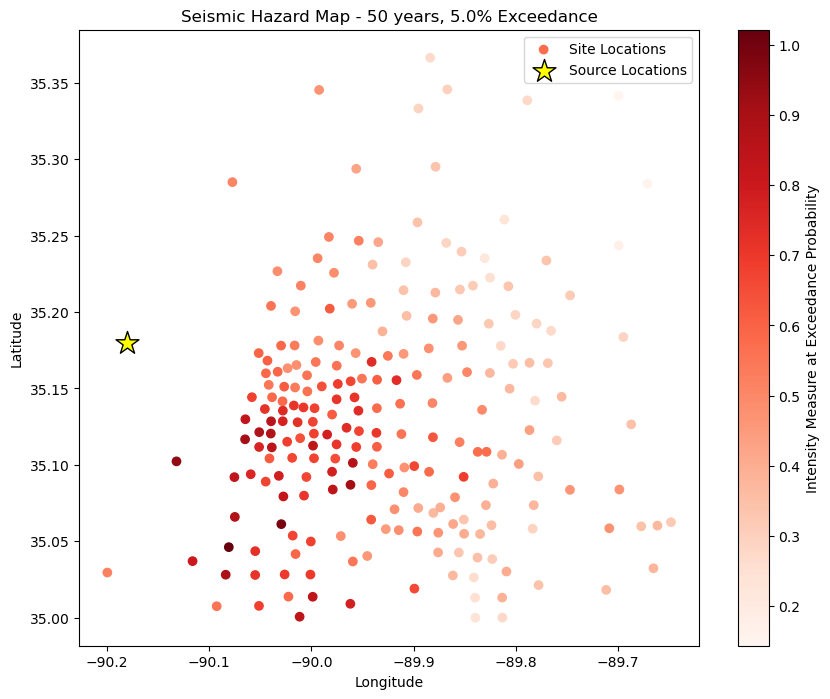

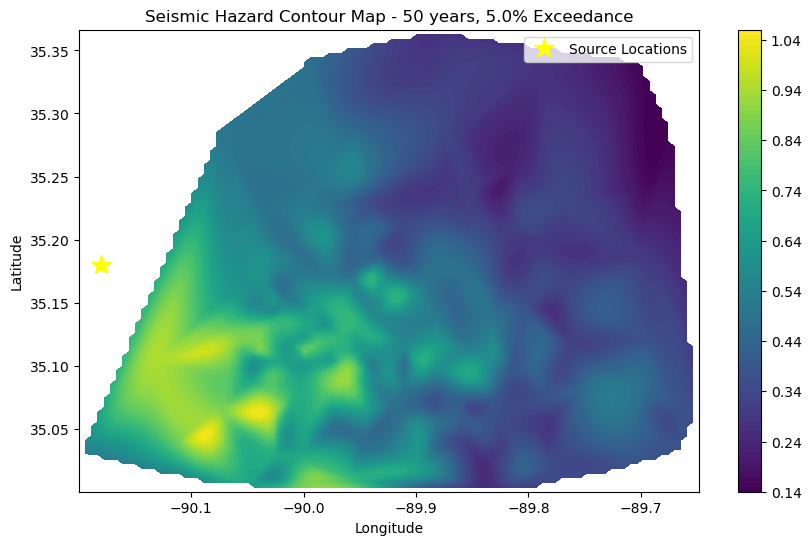

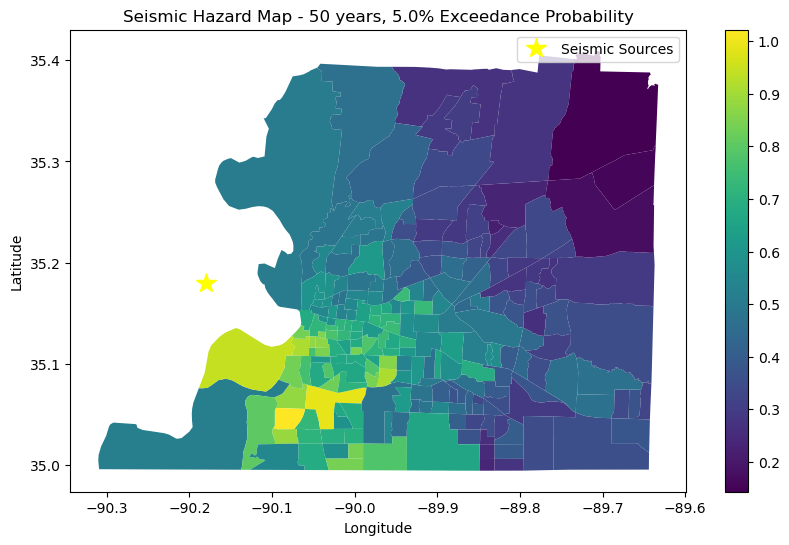

In [6]:
csv_file_path   = 'input_files/site_data.csv'
json_file_path  = 'input_files/source_data.json'

setup = InitialSetup(csv_file_path, json_file_path)


magnitude_frequency_distribution = 'gr_recurrence_law'
ground_motion_equation_model     = 'BooreStewartSeyhanAtkinson2014' #'AbrahamsonSilvaKamai2014' #'AbrahamsonGregorAddo2016'

earthquake_generator = EarthquakeGenerator(setup, magnitude_frequency_distribution, ground_motion_equation_model, ground_motion_type='PGA', num_scenarios=10)
intensity_measures_dict, intensity_measures_df = earthquake_generator.generate_earthquake_objects()


census_file_path  = 'input_files/shapefiles/shelby_county_census_tracts.shp'
geotiff_file_path = '/outputs'

seismic_hazard_visualization = SeismicHazardVisualization(setup, intensity_measures_dict, return_period=50)

seismic_hazard_visualization.plot_hazard_map(exceedance_probability=0.05)
seismic_hazard_visualization.plot_contour_map(exceedance_probability=0.05)

#seismic_hazard_visualization.generate_earthquake_geotiff(exceedance_probability=0.05, geotiff_file_path = geotiff_file_path)
#seismic_hazard_visualization.generate_continuous_earthquake_geotiff(exceedance_probability=0.05, grid_resolution=0.001, geotiff_file_path = geotiff_file_path)

seismic_hazard_visualization.plot_tract_intensity_map(exceedance_probability=0.05, census_file_path = census_file_path)

In [28]:
import numpy as np
import pandas as pd
from pysal.explore.esda.moran import Moran
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import folium
from folium.plugins import HeatMap
import plotly.graph_objs as go
from scipy.spatial import ConvexHull
import time

C:\Users\COOL J\anaconda3\Lib\site-packages\spaghetti\network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


ImportError: cannot import name 'Local_Spatial_Pearson' from 'esda.lee' (C:\Users\COOL J\anaconda3\Lib\site-packages\esda\lee.py)

In [31]:
from esda.moran import Moran

In [11]:
from sklearn.cluster import DBSCAN
#from geopy.distance import great_circle
from shapely.geometry import Point
import numpy as np

def perform_spatial_clustering(site_data, epsilon=0.1, min_samples=5):
    # Convert latitude and longitude to radians
    site_data['lat_rad'] = np.radians(site_data['latitude'])
    site_data['lon_rad'] = np.radians(site_data['longitude'])

    # Compute epsilon in kilometers
    kms_per_radian = 6371.0088
    epsilon_km = epsilon / kms_per_radian

    # Initialize DBSCAN clustering
    dbscan = DBSCAN(eps=epsilon_km, min_samples=min_samples, algorithm='ball_tree', metric='haversine')

    # Fit DBSCAN to the spatial data
    site_coords = np.array(site_data[['lat_rad', 'lon_rad']])
    dbscan.fit(site_coords)

    # Add cluster labels to the site data
    site_data['cluster'] = dbscan.labels_

    return site_data

In [12]:
perform_spatial_clustering(df)

,id,latitude,longitude,depth,vs30,condition,lat_rad,lon_rad,cluster
0,47157021312,35.108533,-89.837289,0,250,soil',0.612759,-1.567956,-1
1,47157021530,35.058529,-89.708563,0,250,soil',0.611887,-1.565710,-1
2,47157021726,35.054941,-89.850607,0,250,soil',0.611824,-1.568189,-1
3,47157022024,35.041668,-90.015503,0,250,soil',0.611592,-1.571067,-1
4,47157000200,35.168239,-90.043007,0,250,soil',0.613802,-1.571547,-1
...,...,...,...,...,...,...,...,...,...
216,47157011020,35.040395,-89.945357,0,250,soil',0.611570,-1.569843,-1
217,47157004300,35.129869,-90.064625,0,250,soil',0.613132,-1.571924,-1
218,47157020634,35.217274,-89.841949,0,250,soil',0.614657,-1.568038,-1
219,47157021020,35.126533,-89.687131,0,250,soil',0.613074,-1.565336,-1


In [ ]:
import requests

def integrate_real_time_data():
    # Mock API endpoint for real-time data
    api_endpoint = 'https://api.example.com/real-time-data'

    try:
        # Fetch real-time data from the API
        response = requests.get(api_endpoint)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Process the real-time data (replace this with actual processing logic)
        real_time_data = response.json()

        # Example processing: Print the received data
        print("Real-time data received:", real_time_data)

        # Return the processed data (if needed)
        return real_time_data

    except requests.exceptions.RequestException as e:
        # Handle connection errors or HTTP request errors
        print("Error fetching real-time data:", e)
        return None

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

def train_regression_model(intensity_measures_df):
    # Split data into features (X) and target (y)
    X = intensity_measures_df[['site_id', 'scenarion_index', 'magnitude', 'distance']]
    y = intensity_measures_df['intensity_measure']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train a Random Forest Regressor model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model, X_test, y_test

def evaluate_regression_model(model, X_test, y_test):
    # Evaluate the regression model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5

    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)

    return mse, rmse

def train_classification_model(intensity_measures_df):
    # Assume intensity measure is converted to a binary classification task
    # For example, if intensity_measure > threshold, classify as 1, else 0
    threshold = 0.5
    intensity_measures_df['binary_intensity'] = (intensity_measures_df['intensity_measure'] > threshold).astype(int)

    # Split data into features (X) and target (y)
    X = intensity_measures_df[['site_id', 'scenarion_index', 'magnitude', 'distance']]
    y = intensity_measures_df['binary_intensity']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train a Random Forest Classifier model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model, X_test, y_test

def evaluate_classification_model(model, X_test, y_test):
    # Evaluate the classification model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy:", accuracy)

    return accuracy

In [8]:
# Step 2: Prepare your data
# intensity_measures_df should contain the required columns: 'site_id', 'scenarion_index', 'magnitude', 'distance', and 'intensity_measure'
# Ensure that intensity_measure is numeric and is suitable for either regression or classification based on your task.

# Step 3: Train the regression model
model_regression, X_test_regression, y_test_regression = train_regression_model(intensity_measures_df)

In [9]:
# Step 4: Make predictions and evaluate the regression model
mse, rmse = evaluate_regression_model(model_regression, X_test_regression, y_test_regression)

Mean Squared Error (MSE): 0.006927029277929296
Root Mean Squared Error (RMSE): 0.0832287767417574


In [10]:
# Step 5: Train the classification model
model_classification, X_test_classification, y_test_classification = train_classification_model(intensity_measures_df)

In [11]:
# Step 6: Make predictions and evaluate the classification model
accuracy = evaluate_classification_model(model_classification, X_test_classification, y_test_classification)

Accuracy: 0.9230769230769231


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve

def evaluate_regression_model(model, X_test, y_test):
    # Evaluate the regression model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = model.score(X_test, y_test)
    mae = np.mean(np.abs(y_pred - y_test))
    median_ae = np.median(np.abs(y_pred - y_test))

    return {"MSE": mse, "RMSE": rmse, "R2": r2, "MAE": mae, "Median Absolute Error": median_ae}, y_pred

def evaluate_classification_model(model, X_test, y_test):
    # Evaluate the classification model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    return {"Accuracy": accuracy, "Confusion Matrix": confusion, "Classification Report": class_report, 
            "ROC AUC": roc_auc, "Precision Recall Curve": (precision, recall), "ROC Curve": (fpr, tpr)}, y_pred

# Evaluate the regression model
regression_metrics, y_pred_regression = evaluate_regression_model(model_regression, X_test_regression, y_test_regression)

# Evaluate the classification model
classification_metrics, y_pred_classification = evaluate_classification_model(model_classification, X_test_classification, y_test_classification)

# Display the results using tabulate
print("Regression Metrics:")
print(tabulate(regression_metrics.items(), headers=["Metric", "Value"], tablefmt="grid"))

print("\nClassification Metrics:")
print(tabulate(classification_metrics.items(), headers=["Metric", "Value"], tablefmt="grid"))


Regression Metrics:
+-----------------------+------------+
| Metric                |      Value |
+=======================+============+
| MSE                   | 0.00692703 |
+-----------------------+------------+
| RMSE                  | 0.0832288  |
+-----------------------+------------+
| R2                    | 0.737129   |
+-----------------------+------------+
| MAE                   | 0.0594973  |
+-----------------------+------------+
| Median Absolute Error | 0.0411621  |
+-----------------------+------------+

Classification Metrics:
+------------------------+--------------------------------------------------------------------------------------------+
| Metric                 | Value                                                                                      |
+========================+============================================================================================+
| Accuracy               | 0.9230769230769231                                           

In [17]:
# Plotting
# Residual Plot for Regression
plt.figure(figsize=(10, 5))
sns.residplot(y_test_regression, y_pred_regression, lowess=True, color="g")
plt.title("Residual Plot for Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

TypeError: residplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

<Figure size 1000x500 with 0 Axes>

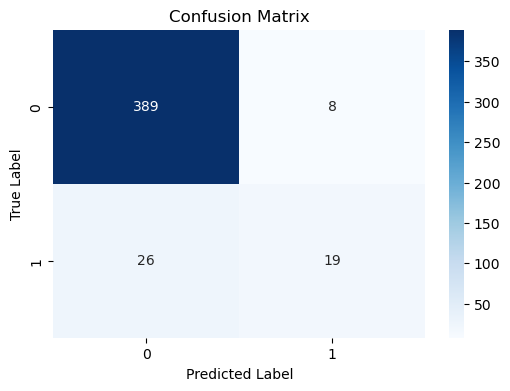

In [21]:
# Confusion Matrix for Classification
plt.figure(figsize=(6, 4))
sns.heatmap(classification_metrics["Confusion Matrix"], annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

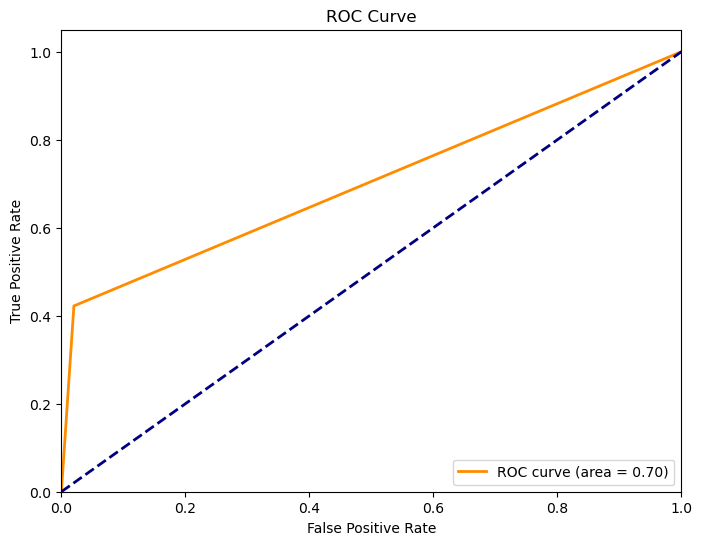

In [19]:
# ROC Curve for Classification
plt.figure(figsize=(8, 6))
plt.plot(classification_metrics["ROC Curve"][0], classification_metrics["ROC Curve"][1], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % classification_metrics["ROC AUC"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

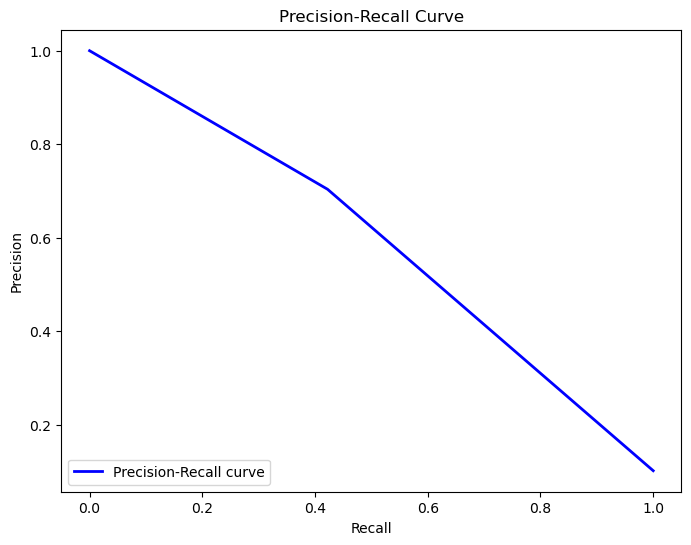

In [20]:
# Precision-Recall Curve for Classification
plt.figure(figsize=(8, 6))
plt.plot(classification_metrics["Precision Recall Curve"][1], classification_metrics["Precision Recall Curve"][0], color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()